### 3. EXPLORATORY DATA ANALYSIS

In this section I explore the distribution of garbage underlying cause codes by demographic characterisitics of the decedents as well as the county of death and the credentials of the medical certifiers who reported these causes of death.

In [57]:
import ast
import collections
from collections import Counter
import imp
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
ds =  pd.read_csv('Y:/DQSS/Death/MBG/py/capstone2/data/d1619_clean_preproctxt.csv',
                  low_memory=False,
                  encoding = 'unicode_escape')

In [3]:
len(ds)

7770

In [4]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', None)

In [5]:
d = ds.copy()

**The data set is reduced** from 226,997 death records to 7,770 records that had garbage codes (GC) as an underlying cause code but contained valid codes in multiple cause fields 2 through 20.

In [7]:
# create function to make barplots
def make_barplot_bygrp(x, hue, df, title):
    df=ds.loc[ds['gc_cat']!=0, :]
    percentage = lambda x: len(x)/float(len(df)) *100
    plt.figure(figsize=(9, 7))
    ax=sns.barplot(x=x, y=x, hue=hue, data= df, estimator=percentage, orient='h')
    ax.set(xlabel="Percent")
    ax.set(ylabel="GC category")
    ax.set(title = title)
    plt.show()    

**TYPES OF GARBAGE ICD-10 CODES** in the underlying cause of death field.

In [8]:
ds['gc_cat_label'].value_counts(normalize=True).round(3)*100

6-Ill-defined cardiovascular    31.4
1-Septicemia                    22.3
2-Heart failure                 19.3
3-Ill-defined cancer            18.7
4-Volume depletion               5.8
8-Undetermined intent            2.0
5-Ill-defined                    0.5
Name: gc_cat_label, dtype: float64

In [9]:
ds['gc_cat_label'].value_counts()

6-Ill-defined cardiovascular    2439
1-Septicemia                    1733
2-Heart failure                 1499
3-Ill-defined cancer            1453
4-Volume depletion               449
8-Undetermined intent            158
5-Ill-defined                     39
Name: gc_cat_label, dtype: int64

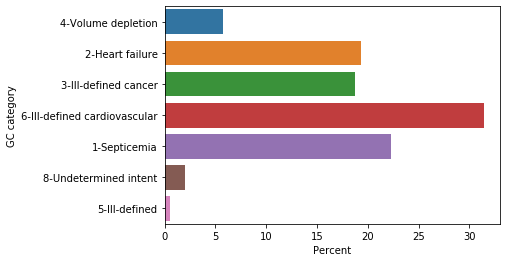

In [10]:
# frequency plot of records by garbage code category

ax=sns.barplot(x='gc_cat_label', y='gc_cat_label', data= ds, estimator=lambda x: len(x)/float(len(ds)) *100, orient='h')
ax.set(xlabel="Percent")
ax.set(ylabel="GC category")
plt.show()    

   Heart failure, ill-defined cancer, and ill-defined cardiovascular conditions (categories 2, 3, and 6 in the table above) together account for over half the roughly 15,000 records with garbage codes for this period. Undetermined intent and ill-defined infectious conditions (categories 8 and 9) are the categories with the fewest records. I will exclude categories with smaller numbers of records as the results may not be reliable.  

**Tobacco use contributing to death.**  Death registration in Washington State is entirely done electronically.  A drop down menu in death records requires that medical certifiers report whether tobacco use contributed to the death.  The response choices are:
- Y - yes
- P - probably
- N - no
- U - unknown

Initial analysis of ICD-10 frequency indicated that ICD-10 code F17.9  is present in 1,893 out of the 15,073 records i.e. in approximately 13% of the death records with garbage underlying cause codes. This is the code for "mental and behavioral disorders due to use of tobacco" and indicates that the medical certifier believed that tobacco use definitely or probably contributed to the death.  

In [11]:
ds['tobac'] = ds['tobac'].fillna('U')
ds['tobac'] = ds['tobac'].replace(['Y', 'P'], "Yes/Probably")
ds['tobac'] = ds['tobac'].replace(['N'], "No")
ds['tobac'] = ds['tobac'].replace(['U'], "Unknown")

In [12]:
ds.tobac.value_counts(dropna=False)

No              3947
Unknown         2492
Yes/Probably    1331
Name: tobac, dtype: int64

**A crosstabulation of tobacco use by garbage code** shows that in almost 20% of 'ill-defined cancer' deaths and 17% of ill-defined cardiovascualr deaths tobacco use was reported as definitely or probably a contributor to death.

In [13]:
round(pd.crosstab(ds.gc_cat_label, ds.tobac, normalize = "index")*100,1)

tobac,No,Unknown,Yes/Probably
gc_cat_label,,,
1-Septicemia,55.6,31.9,12.5
2-Heart failure,49.4,34.2,16.4
3-Ill-defined cancer,44.5,33.6,22.0
4-Volume depletion,58.8,29.0,12.2
5-Ill-defined,82.1,15.4,2.6
6-Ill-defined cardiovascular,49.4,30.7,19.9
8-Undetermined intent,60.8,34.8,4.4


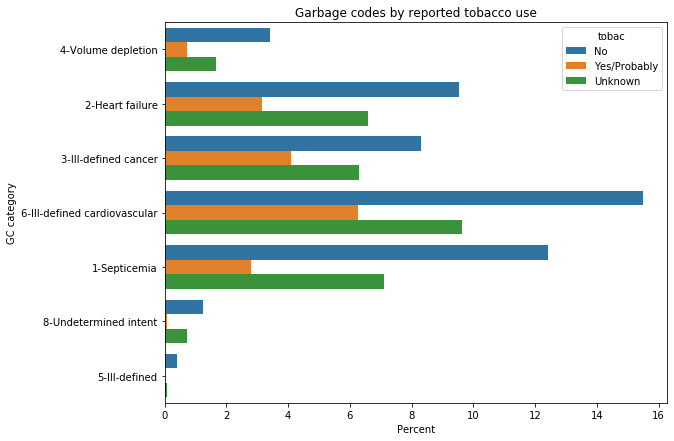

In [14]:
make_barplot_bygrp('gc_cat_label', 'tobac', ds, "Garbage codes by reported tobacco use")

**GC category by gender**

In [15]:
round(pd.crosstab(ds['gc_cat_label'], ds['sex'], normalize ='index')*100,1), pd.crosstab(ds['gc_cat_label'], ds['sex'])

(sex                              F     M
 gc_cat_label                            
 1-Septicemia                  48.2  51.8
 2-Heart failure               51.5  48.5
 3-Ill-defined cancer          50.0  50.0
 4-Volume depletion            59.7  40.3
 5-Ill-defined                 59.0  41.0
 6-Ill-defined cardiovascular  50.9  49.1
 8-Undetermined intent         50.6  49.4,
 sex                              F     M
 gc_cat_label                            
 1-Septicemia                   836   897
 2-Heart failure                772   727
 3-Ill-defined cancer           727   726
 4-Volume depletion             268   181
 5-Ill-defined                   23    16
 6-Ill-defined cardiovascular  1242  1197
 8-Undetermined intent           80    78)

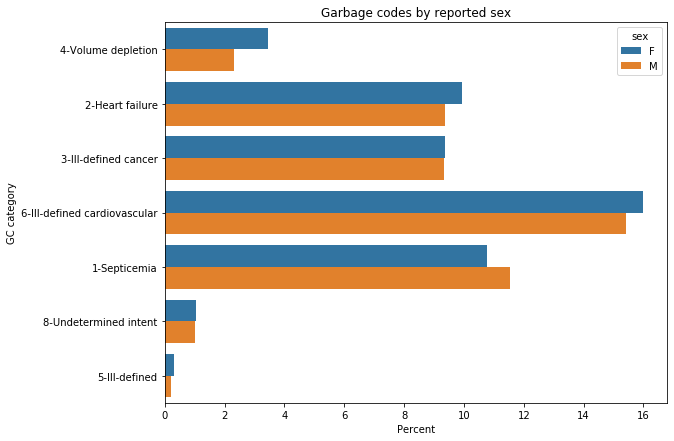

In [16]:
make_barplot_bygrp('gc_cat_label', 'sex', ds, "Garbage codes by reported sex")

Crosstabulation of each category by gender shows that women are more likely to have garbage codes related to 2-Heart failure, 4-Volume depletion, and 6-Ill-defined cardiovascular.  Men are more likely to receive an undetermined intent code.

**GC category by age group**

In [17]:
# Distribution of GC codes by GC category and age group - row percentages
round(pd.crosstab(ds['gc_cat_label'], ds['agegrp'], normalize="columns"), 3)*100


agegrp,0-19 yrs,20-29 yrs,30-39 yrs,40-49 yrs,50-59 yrs,60-69 yrs,70-79 yrs,80+ yrs
gc_cat_label,,,,,,,,
1-Septicemia,31.2,22.4,29.1,24.2,23.2,25.9,25.1,19.3
2-Heart failure,0.0,1.7,5.8,5.9,10.7,11.0,16.2,26.6
3-Ill-defined cancer,18.8,6.9,16.5,19.2,18.7,26.0,22.6,14.8
4-Volume depletion,6.2,10.3,2.9,4.1,5.3,4.0,5.6,6.6
5-Ill-defined,0.0,1.7,0.0,0.0,0.2,0.2,0.2,0.6
6-Ill-defined cardiovascular,31.2,25.9,24.3,32.9,35.5,30.9,29.8,31.9
8-Undetermined intent,12.5,31.0,21.4,13.7,6.5,2.1,0.5,0.2


In [18]:
pd.crosstab(ds['gc_cat_label'], ds['agegrp'])

agegrp,0-19 yrs,20-29 yrs,30-39 yrs,40-49 yrs,50-59 yrs,60-69 yrs,70-79 yrs,80+ yrs
gc_cat_label,,,,,,,,
1-Septicemia,5,13,30,53,150,328,428,721
2-Heart failure,0,1,6,13,69,139,276,995
3-Ill-defined cancer,3,4,17,42,121,329,385,552
4-Volume depletion,1,6,3,9,34,50,95,248
5-Ill-defined,0,1,0,0,1,2,4,24
6-Ill-defined cardiovascular,5,15,25,72,230,391,507,1192
8-Undetermined intent,2,18,22,30,42,26,9,8


Ill-defined cardiovascular disease accounts for the greatest proportion of GC underlying cause codes for decedents who were 50 years and older. For decedents below the age of 50 years the catch all 'ill-defined other' category accounted for the greatest proportion of GC deaths. Ill defined (other) and undetermined intent accounted for most of the GC underlying cause codes among decedents aged 0 to 19 years.  Ill-defined infectious diseases were the least common type of GC underlying cause code across all age groups.

**GC category by race**

In [19]:
# Distribution of GC categories by race - 
pd.crosstab(ds['gc_cat_label'], ds['race'], normalize="columns").round(3)*100

race,AIAN,African Am.,Asian,Other/multirace,Pacific Isl.,Unknown,White
gc_cat_label,,,,,,,
1-Septicemia,36.6,23.7,21.0,28.3,37.5,21.1,21.8
2-Heart failure,12.2,13.7,17.7,16.7,27.1,26.3,19.7
3-Ill-defined cancer,11.4,15.3,21.0,19.4,6.2,21.1,18.9
4-Volume depletion,6.5,5.7,8.1,5.0,2.1,5.3,5.7
5-Ill-defined,0.0,0.0,0.0,0.0,0.0,0.0,0.6
6-Ill-defined cardiovascular,26.0,39.3,30.2,28.3,27.1,26.3,31.4
8-Undetermined intent,7.3,2.3,2.1,2.2,0.0,0.0,1.9


In [20]:
# Distribution of GC categories by race - counts
pd.crosstab(ds['gc_cat_label'], ds['race'])

race,AIAN,African Am.,Asian,Other/multirace,Pacific Isl.,Unknown,White
gc_cat_label,,,,,,,
1-Septicemia,45,62,70,51,18,4,1483
2-Heart failure,15,36,59,30,13,5,1341
3-Ill-defined cancer,14,40,70,35,3,4,1287
4-Volume depletion,8,15,27,9,1,1,388
5-Ill-defined,0,0,0,0,0,0,39
6-Ill-defined cardiovascular,32,103,101,51,13,5,2134
8-Undetermined intent,9,6,7,4,0,0,132


Other ill-defined conditions accounted for almost 38% of the GC underlying cause codes among American Indian/Alaska Native decedents and about 33% of multi-racial decedents.  In comparison this category accounted for only 14% of GC underlying cause codes among Asian decedents. Among White decedents the largest category of GC deaths accounting for almost 26% of records with garbage underlying cause codes was ill-defined cardiovascular disease.This was also true for African American decedents; over 32% of death records with garbage underlying cause codes fell into the ill-defined cardiovascular disease category.

**GC category by ethnicity**

In [21]:
# Distribution of GC categories by ethnicity - counts
pd.crosstab(ds['gc_cat_label'], ds['hispanic'], normalize="columns").round(3)*100

hispanic,No,Yes
gc_cat_label,,
1-Septicemia,22.0,31.1
2-Heart failure,19.5,14.2
3-Ill-defined cancer,18.7,17.3
4-Volume depletion,5.8,3.9
5-Ill-defined,0.5,0.8
6-Ill-defined cardiovascular,31.5,26.8
8-Undetermined intent,1.9,5.9


In [22]:
# Distribution of GC categories by ethnicity- counts
pd.crosstab(ds['gc_cat_label'], ds['hispanic'])

hispanic,No,Yes
gc_cat_label,,
1-Septicemia,1654,79
2-Heart failure,1463,36
3-Ill-defined cancer,1409,44
4-Volume depletion,439,10
5-Ill-defined,37,2
6-Ill-defined cardiovascular,2371,68
8-Undetermined intent,143,15


For Hispanic decedents, other ill-defined conditions and ill-defined cardiovascular disease accounted for half the garbage underlying cause codes.

**GC category by death county**

This table shows the distribution of garbage code categories within each county. In most counties, ill-defined cardiovascular and heart failure together account for the greatest proportion of garbage codes in each county, often accounting for over half the deaths with garbage underlying cause codes.

In [23]:
# Distribution of GC categories by county - row percentages
pd.crosstab(ds['dcounty'], ds['gc_cat_label'], normalize='index').round(3)*100

gc_cat_label,1-Septicemia,2-Heart failure,3-Ill-defined cancer,4-Volume depletion,5-Ill-defined,6-Ill-defined cardiovascular,8-Undetermined intent
dcounty,,,,,,,
ADAMS,22.2,11.1,11.1,0.0,11.1,44.4,0.0
ASOTIN,25.0,32.1,14.3,3.6,0.0,25.0,0.0
BENTON,27.9,10.3,18.0,9.0,0.4,32.2,2.1
CHELAN,15.3,16.9,29.8,4.0,0.8,32.3,0.8
CLALLAM,19.0,23.0,17.0,5.0,0.0,33.0,3.0
CLARK,20.1,18.8,23.2,7.9,0.4,28.6,1.0
COLUMBIA,0.0,0.0,20.0,0.0,0.0,80.0,0.0
COWLITZ,31.4,26.3,19.4,2.9,0.6,18.9,0.6
DOUGLAS,8.0,28.0,48.0,4.0,0.0,12.0,0.0


In [24]:
# Distribution of GC categories by county - counts
pd.crosstab(ds['dcounty'], ds['gc_cat_label'])

gc_cat_label,1-Septicemia,2-Heart failure,3-Ill-defined cancer,4-Volume depletion,5-Ill-defined,6-Ill-defined cardiovascular,8-Undetermined intent
dcounty,,,,,,,
ADAMS,2,1,1,0,1,4,0
ASOTIN,7,9,4,1,0,7,0
BENTON,65,24,42,21,1,75,5
CHELAN,19,21,37,5,1,40,1
CLALLAM,19,23,17,5,0,33,3
CLARK,104,97,120,41,2,148,5
COLUMBIA,0,0,1,0,0,4,0
COWLITZ,55,46,34,5,1,33,1
DOUGLAS,2,7,12,1,0,3,0


The tendency toward assigning an ill-defined cardiovascular disease code or other ill-defined condition code is apparent across most counties.

**GC category by medical certifier types**

In [25]:
#GC category by medical certifier type - column percentages
pd.crosstab(ds['cert_label'],ds['gc_cat_label'], normalize="columns").round(3)*100

gc_cat_label,1-Septicemia,2-Heart failure,3-Ill-defined cancer,4-Volume depletion,5-Ill-defined,6-Ill-defined cardiovascular,8-Undetermined intent
cert_label,,,,,,,
1-Physician,79.1,70.6,75.4,74.8,56.4,64.2,3.8
2-ME/Coroner,3.1,4.3,2.3,8.7,23.1,15.5,95.6
3-DO,6.6,6.9,6.6,5.8,2.6,5.6,0.0
6-PA,2.7,3.7,2.8,2.4,5.1,2.9,0.6
7-ARNP,7.6,13.4,12.7,7.3,10.3,11.2,0.0
9-Unknown,0.9,1.0,0.3,0.9,2.6,0.6,0.0


In [26]:
pd.crosstab(ds['cert_label'],ds['gc_cat_label'])

gc_cat_label,1-Septicemia,2-Heart failure,3-Ill-defined cancer,4-Volume depletion,5-Ill-defined,6-Ill-defined cardiovascular,8-Undetermined intent
cert_label,,,,,,,
1-Physician,1371,1059,1095,336,22,1566,6
2-ME/Coroner,53,64,33,39,9,379,151
3-DO,115,104,96,26,1,136,0
6-PA,47,56,40,11,2,71,1
7-ARNP,132,201,184,33,4,272,0
9-Unknown,15,15,5,4,1,15,0


As physicians are the largest group of cause of death certifiers, it is no surprise that the largest proportion of most GC categories are attributable to them. One exception is other ill-defined conditions. Medical examiners and coroners contribute the most to this type of GC underlying cause code.
<br> 
<br> 

**BAG OF WORDS ANALYSIS**

As stated in the introduction, I chose to use ICD-10 codes for natural language processing (NLP) rather than the cause of death literal text because of the inherent advantages the coding system presents. The rest of this section examines the frequency of various cause of death codes in multiple cause 1 through multiple cause 20 fields.
<br> 
<br>

In [35]:
len(ds)

7770

The data set is further reduced to 7,770 records after I removed records that had empty cells in the 'clean_mc' variable.  This variable was created by removing all GC codes from both the underlying cause code and all multiple cause codes. This indicates that roughly half of the records with garbage underlying cause codes had no other valid codes in their causes of death.

In [38]:
mc_gc_list = [a for b in ds['clean_mcgc'] for a in ast.literal_eval(b)]
mc_list = [a for b in ds['short_mc'] for a in ast.literal_eval(b)]
mc_bigram = [a for b in ds['all_bigrams'] for a in ast.literal_eval(b)]

In [39]:
## function to create bag of word most common words and plot

def create_bow_plot(tokens_list, title):
    bow = Counter(tokens_list)
    top20=bow.most_common(20)
    print('***' + title + '***')
    print("Twenty most common ICD-10 codes:")
    print(top20)
    top20df=pd.DataFrame(top20, columns=['Code', 'Count'])
    plt.figure(figsize=(9, 7))
    plt.bar(top20df['Code'], top20df['Count'])
    plt.title("Bag of words - " + title)
    plt.xticks(rotation=45, ha='right')
    plt.show()
    
    

***ICD-10 SHORT CODES INCLUDING GCs***
Twenty most common ICD-10 codes:
[('J96', 1551), ('F17', 1327), ('I46', 1243), ('I48', 875), ('J44', 746), ('N17', 649), ('C78', 645), ('I50', 641), ('J18', 632), ('N18', 547), ('I10', 536), ('E14', 522), ('F03', 507), ('A49', 466), ('C79', 447), ('R09', 422), ('G93', 408), ('E78', 381), ('R57', 380), ('E11', 379)]


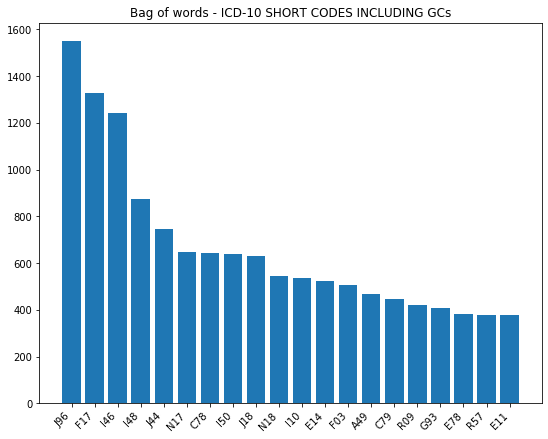

In [40]:
create_bow_plot(mc_gc_list, "ICD-10 SHORT CODES INCLUDING GCs")

**With GCs in the corpus** the three most common ICD-10 codes are J96 (respiratory failure), F17 ('mental and behavioral disorders due to use of tobacco'), and I46 (cardiac arrest).

***ICD-10 SHORT CODES EXCLUDING GCs***
Twenty most common ICD-10 codes:
[('I48', 875), ('J44', 746), ('N17', 649), ('C78', 645), ('J18', 632), ('N18', 547), ('E14', 522), ('F03', 507), ('A49', 466), ('C79', 447), ('G93', 408), ('E78', 381), ('E11', 379), ('I25', 313), ('N28', 305), ('F01', 288), ('E66', 266), ('G30', 253), ('J69', 237), ('N19', 206)]


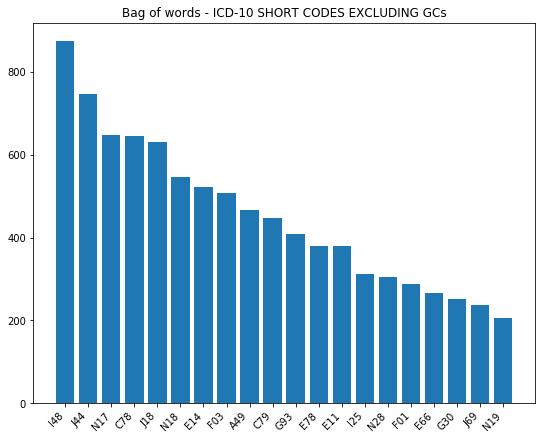

In [41]:
create_bow_plot(mc_list, "ICD-10 SHORT CODES EXCLUDING GCs")

**After removing GCs from the corpus** the most three common ICD-10 codes are I48 (atrial fibrillation), J44 (COPD), and N17 (acute renal failure).

The following codes also dominate the category-specific bags of words plots:

- J96.0 - Acute respiratory failure
- J96.9 - Respiratory failure unspecified
- J18.9 - Pneumonia
- J44.9 - Chronic obstructive pulmonary disease
- N17.9 - Acute renal failure
- F17.9 - Mental and behavioral disorders due to use of tobacco
- C78.7 - Secondary malignant neoplasm of liver and intrahepatic bile duct
- C78.0 - Secondary malignant neoplasm of lung 
- C79.5 - Secondary malignant neoplasm of bone and bone marrow
- C79.8 - Secondary malignant neoplasm of other specified sites
- I48   - Atrial fibrillation
- E78.5 - Hyperlipidemia, unspecified


***ICD-10 BIGRAMS EXCLUDING GCs***
Twenty most common ICD-10 codes:
[('N179_N189', 76), ('I48_J449', 69), ('C780_C787', 63), ('I48_J189', 49), ('J189_N179', 46), ('F03_I48', 43), ('C787_C795', 39), ('E149_E785', 37), ('I251_I48', 37), ('I48_I64', 37), ('J189_J80', 32), ('C787_C788', 28), ('F03_J189', 27), ('E119_E785', 27), ('F019_I48', 27), ('E785_F019', 26), ('N179_N390', 25), ('G309_I48', 25), ('E149_E669', 24), ('C795_C798', 23)]


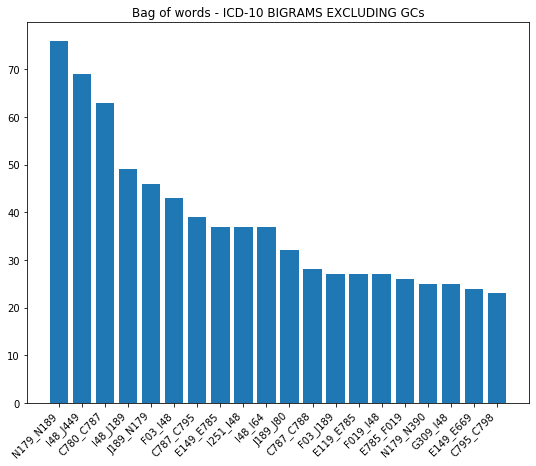

In [42]:
create_bow_plot(mc_bigram, "ICD-10 BIGRAMS EXCLUDING GCs")

Bigrams of adjacent ICD-10 codes provide an added level of detail by providing context to each code.  The most common bigram is N17.9-N718.9 which are acute renal failure and chronic kidney disease unspecified.  The next most common bigrams are I48-J44.9 (atrial fibrillation and COPD) and C78.0-C78.7 (secondary malignant neoplasm of lung and secondary malignant neoplasm of liver. These codes already provide some indication of the cause of death categories to which these records might be reassigned.

**Create bag of words for each garbage code category**

In the following section I created bag of words plots for GC categories separately.  I selected only those categories that have more than 1,000 records.

** GC category: 1-SEPTICEMIA SHORT ICD-10 codes**
[('J189', 303), ('N179', 289), ('I48', 195), ('A490', 149), ('A499', 125), ('F03', 115), ('N288', 112), ('I251', 100), ('N390', 98), ('A498', 91)]


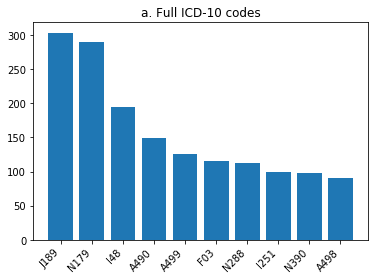

** GC category: 1-SEPTICEMIA BIGRAMS of ICD-10 codes**
[('I48_J189', 29), ('J189_J80', 26), ('N179_N189', 26), ('I251_I48', 25), ('J189_N179', 24), ('F03_J189', 14), ('I48_J449', 14), ('N179_N390', 14), ('J80_N179', 13), ('I48_J440', 13)]


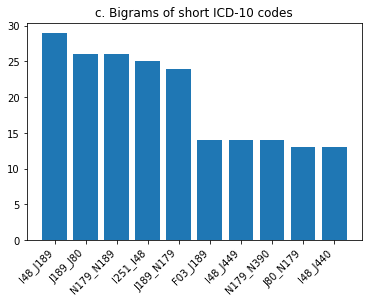

** GC category: 2-HEART FAILURE SHORT ICD-10 codes**
[('J449', 194), ('J189', 139), ('F03', 133), ('N189', 133), ('N179', 118), ('I48', 111), ('N19', 74), ('N185', 68), ('E149', 63), ('N288', 55)]


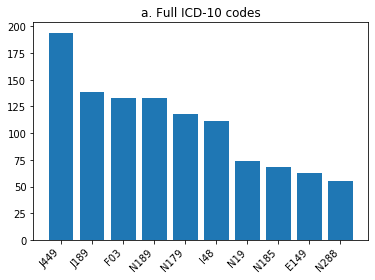

** GC category: 2-HEART FAILURE BIGRAMS of ICD-10 codes**
[('N179_N189', 30), ('I48_J449', 13), ('I48_I64', 11), ('F03_J449', 9), ('J189_N179', 9), ('E668_G473', 8), ('F03_J189', 7), ('J449_N189', 7), ('F03_I48', 7), ('I48_I634', 6)]


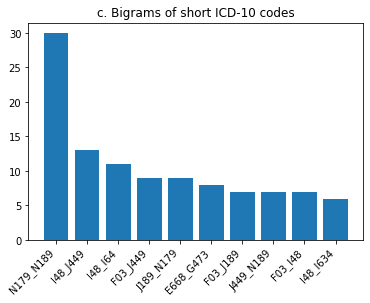

** GC category: 3-ILL-DEFINED CANCER SHORT ICD-10 codes**
[('C787', 226), ('C780', 199), ('C795', 151), ('C798', 129), ('J449', 117), ('I48', 103), ('C793', 92), ('C786', 79), ('N179', 73), ('J189', 70)]


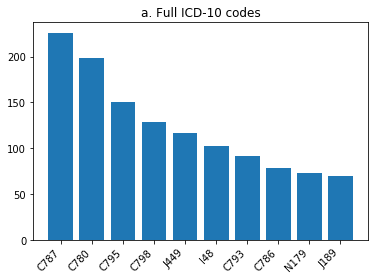

** GC category: 3-ILL-DEFINED CANCER BIGRAMS of ICD-10 codes**
[('C780_C787', 61), ('C787_C795', 38), ('C787_C788', 27), ('C795_C798', 23), ('C780_C798', 22), ('C780_C795', 19), ('C780_C793', 17), ('I48_J449', 16), ('C787_C793', 16), ('C793_C795', 15)]


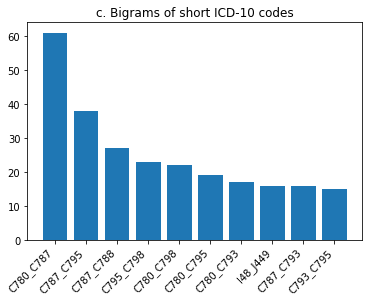

** GC category: 6-ILL-DEFINED CARDIOVASCULAR SHORT ICD-10 codes**
[('I48', 411), ('E785', 230), ('J449', 224), ('F019', 206), ('E149', 176), ('F03', 151), ('G931', 110), ('E119', 105), ('E669', 103), ('G309', 86)]


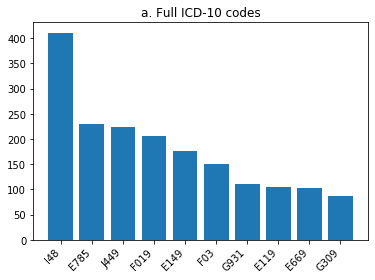

** GC category: 6-ILL-DEFINED CARDIOVASCULAR BIGRAMS of ICD-10 codes**
[('E149_E785', 26), ('F019_I48', 25), ('E785_F019', 24), ('I48_J449', 23), ('F03_I48', 23), ('E149_E669', 16), ('E119_E785', 16), ('E785_I48', 15), ('E669_E785', 12), ('E785_J449', 12)]


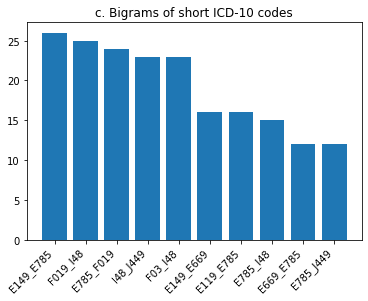

In [56]:
%store -r gc_label_dict

for i in [1, 2, 3, 6]:
    cat_recs = ds.loc[ds['gc_cat']== i, ['clean_mc']]
    mc_list = [a for b in cat_recs['clean_mc'] for a in ast.literal_eval(b)]
    print('** GC category: ' + gc_label_dict.get(i).upper() + ' SHORT ICD-10 codes**')
    bow_simple = Counter(mc_list)
    bow10 = bow_simple.most_common(10)
    print(bow10)
    bow10df = pd.DataFrame(bow10, columns=['Code', 'Count'])
    plt.bar(bow10df['Code'], bow10df['Count'])
    plt.title('a. Full ICD-10 codes')
    plt.xticks(rotation=45, ha='right')
    plt.show()
    
    cat_recs3 = ds.loc[ds['gc_cat']== i, ['all_bigrams']]
    mc_bi = [a for b in cat_recs3['all_bigrams'] for a in ast.literal_eval(b)]
    print('** GC category: ' + gc_label_dict.get(i).upper() + ' BIGRAMS of ICD-10 codes**')
    bow_bi = Counter(mc_bi)
    bow_bi10 = bow_bi.most_common(10)
    print(bow_bi10)
    bow_bi10df = pd.DataFrame(bow_bi10, columns=['Bigram', 'Count'])
    plt.bar(bow_bi10df['Bigram'], bow_bi10df['Count'])
    plt.title('c. Bigrams of short ICD-10 codes')
    plt.xticks(rotation=45, ha='right')
    plt.show()

**Next section: 4_Latent Dirichlet Allocation**